In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [2]:
import os
import time
import random
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics


In [3]:
import torch
import torch.nn as nn
from torch import cuda
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

## Config

In [4]:
device = 'cuda' if cuda.is_available() else 'cpu'
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [5]:
CONFIG = {
    "DEVICE": device,
    "MAX_LEN": 64,
    "TRAIN_BATCH_SIZE": 32,
    "VALID_BATCH_SIZE": 16,
    "EPOCHS": 4,
    "BERT_PATH": "bert-base-uncased",
    "MODEL_PATH": "model_amazon.bin",
    "TRAINING_FILE": "/content/drive/MyDrive/Colab Notebooks/NLP/NER/bert-entity-extraction/bert_class/train.csv",
    "OG_TRAINING_FILE": "/content/drive/MyDrive/Colab Notebooks/NLP/NER/bert-entity-extraction/bert_class/train.csv"
}
#  final_clean_ama.csv

In [6]:
%cd "/content/drive/MyDrive/Colab Notebooks/NLP/NER/bert-entity-extraction/bert_class"

/content/drive/MyDrive/Colab Notebooks/NLP/NER/bert-entity-extraction/bert_class


In [8]:
CONFIG["TOKENIZER"] = transformers.BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

## Dataset

### LoadDataset

In [9]:
class LoadDataset():
    def __init__(self, df=None):
        if not df.empty:
            self.df = df
        else:
            self.df = pd.read_csv(CONFIG['TRAINING_FILE'])

    def get_dataset(self, test=False):
        if test:
            df_train, df_test = train_test_split(
                self.df, test_size=0.1, random_state=RANDOM_SEED)

            df_val, df_test = train_test_split(
                df_test, test_size=0.5, random_state=RANDOM_SEED)

            return df_train, df_val, df_test
        else:
            df_train, df_val = train_test_split(
                self.df, test_size=0.2, random_state=RANDOM_SEED)

            return df_train, df_val

### BERTDataset and BERTDataLoader

In [10]:
class BERTDataset(Dataset):

    def __init__(self, texts, targets):
        self.texts = texts
        self.targets = targets
        self.tokenizer = CONFIG['TOKENIZER']
        self.max_len = CONFIG['MAX_LEN']

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text_text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            "token_type_ids": encoding['token_type_ids'].flatten(),
            'targets': torch.tensor(target, dtype=torch.float)
        }


class BERTDataLoader():

    def create_data_loader(self, df, batch_size):
        bert_dataset = BERTDataset(
            texts=df['text'].to_numpy(),
            targets=df['target'].to_numpy()
        )

        return DataLoader(bert_dataset, batch_size=batch_size, num_workers=4)

In [11]:
# df_train, df_val = LoadDataset().get_dataset()
# df_train.shape, df_val.shape

# data_loader_obj = BERTDataLoader()

# train_data_loader = data_loader_obj.create_data_loader(df_train, CONFIG['TRAIN_BATCH_SIZE'])
# val_data_loader = data_loader_obj.create_data_loader(df_val, CONFIG['VALID_BATCH_SIZE'])
# # test_data_loader = data_loader_obj.create_data_loader(df_test,  CONFIG['VALID_BATCH_SIZE'])


## Model

In [12]:
class BERTBaseUncased(nn.Module):

    def __init__(self):
        super(BERTBaseUncased, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(CONFIG['BERT_PATH'])
        self.drop = nn.Dropout(0.3)
        # self.out = nn.Linear(768, 1)
        self.out = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        output = self.drop(pooled_output)
        return self.out(output)


## Train & Eval

In [13]:
def train_epoch(model, data_loader, loss_fn, device, optimizer, scheduler):
    model = model.train()

    losses = []
    fin_targets = []
    fin_outputs = []
    correct_predictions = 0

    for d in tqdm(data_loader, total=len(data_loader)):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = loss_fn(outputs, targets.view(-1, 1))
        losses.append(loss.item())

        # _, preds = torch.max(outputs, dim=1)
        # correct_predictions += torch.sum(preds == targets)
        fin_targets.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
   
    f_outputs = np.array(fin_outputs) >= 0.5
    accuracy = metrics.accuracy_score(fin_targets, f_outputs)

    return accuracy, np.mean(losses)


def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()

    losses = []
    fin_targets = []
    fin_outputs = []

    with torch.no_grad():
        for d in tqdm(data_loader, total=len(data_loader)):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device, dtype=torch.float)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            loss = loss_fn(outputs, targets.view(-1, 1))
            losses.append(loss.item())

            # _, preds = torch.max(outputs, dim=1)
            # correct_predictions += torch.sum(preds == targets)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    f_outputs = np.array(fin_outputs) >= 0.5
    accuracy = metrics.accuracy_score(fin_targets, f_outputs)

    return accuracy, np.mean(losses)


## Model Training

In [14]:
def get_loss_opt_sche(model):
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.001,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]

    # optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
    optimizer = AdamW(optimizer_parameters, lr=2e-5)

    total_steps = len(train_data_loader) * CONFIG['EPOCHS']
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    loss_fn = nn.BCEWithLogitsLoss().to(device)
    # loss_fn = nn.CrossEntropyLoss().to(device)

    return loss_fn, optimizer, scheduler


In [21]:
d = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/NER/bert-entity-extraction/bert_class/final_clean_ama.csv")
dd = d[['clean_review', 'Score']]
dd.columns = ['text', 'target']

In [22]:
dd = dd.sample(frac=0.1)
dd.shape

(36529, 2)

In [23]:
EPOCHS = CONFIG['EPOCHS']

# load csv datafile
ob = LoadDataset(df=dd)
df_train, df_val, df_test = ob.get_dataset(test=True)
# df_train, df_val = ob.get_dataset()

# get dataloader object for train and test data
data_loader_obj = BERTDataLoader()
train_data_loader = data_loader_obj.create_data_loader(df_train, CONFIG['TRAIN_BATCH_SIZE'])
val_data_loader = data_loader_obj.create_data_loader(df_val, CONFIG['VALID_BATCH_SIZE'])
test_data_loader = data_loader_obj.create_data_loader(df_test,  CONFIG['VALID_BATCH_SIZE'])


In [24]:
# get model
model = BERTBaseUncased()
model.to(device)

# get loss_fn, optimizer, scheduler
loss_fn, optimizer, scheduler = get_loss_opt_sche(model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model, train_data_loader, loss_fn, device, optimizer, scheduler)
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device)
    print(f'Val   loss {val_loss} accuracy {val_acc} \n')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), CONFIG['MODEL_PATH'])
        best_accuracy = val_acc


Epoch 1/4
----------


100%|██████████| 1028/1028 [06:07<00:00,  2.80it/s]


Train loss 0.23860114910422392 accuracy 0.9047937705316949


100%|██████████| 115/115 [00:07<00:00, 15.45it/s]


Val   loss 0.18760588540817086 accuracy 0.9222343921139102 

Epoch 2/4
----------


100%|██████████| 1028/1028 [06:05<00:00,  2.81it/s]


Train loss 0.14691536074254213 accuracy 0.947378026523908


100%|██████████| 115/115 [00:07<00:00, 14.76it/s]


Val   loss 0.2560966415492737 accuracy 0.9101861993428259 

Epoch 3/4
----------


100%|██████████| 1028/1028 [06:09<00:00,  2.78it/s]


Train loss 0.09990458748623156 accuracy 0.9697347609198199


100%|██████████| 115/115 [00:07<00:00, 14.76it/s]


Val   loss 0.26917976454183784 accuracy 0.9216867469879518 

Epoch 4/4
----------


100%|██████████| 1028/1028 [06:06<00:00,  2.81it/s]


Train loss 0.06892875731836168 accuracy 0.9810804234091739


100%|██████████| 115/115 [00:07<00:00, 14.91it/s]

Val   loss 0.3323489323562092 accuracy 0.9211391018619934 



In [72]:
torch.save(model.state_dict(), CONFIG['MODEL_PATH'])

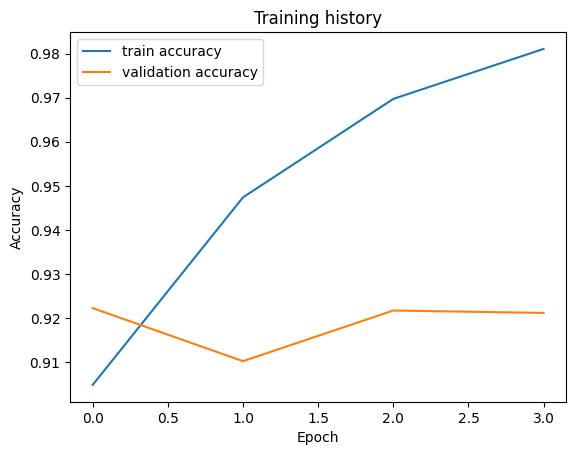

In [26]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
# plt.ylim([0, 1]);

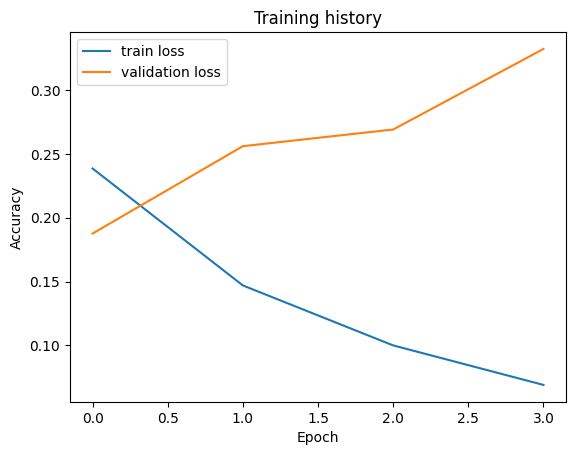

In [27]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
# plt.ylim([0, 1]);

## Test Evaluation

### Load Model

In [28]:
MODEL = BERTBaseUncased()
MODEL.load_state_dict(torch.load(CONFIG['MODEL_PATH']))
MODEL.to(CONFIG['DEVICE'])
MODEL.eval()
DEVICE = CONFIG['DEVICE']
PREDICTION_DICT = dict()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
import torch.nn.functional as F

def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    target_values = []
    predictions = []
    prediction_probs = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["text_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            prediction_probs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
            review_texts.extend(texts)
            target_values.extend(targets.cpu().detach().numpy().tolist())

    predictions = np.where(np.array(prediction_probs) >= 0.5, 1, 0)
    return review_texts, predictions, prediction_probs, target_values

In [62]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [63]:
class_names = ['no_disaster', 'disaster']
class_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.79      0.80      0.80       291
    positive       0.96      0.96      0.96      1536

    accuracy                           0.93      1827
   macro avg       0.88      0.88      0.88      1827
weighted avg       0.93      0.93      0.93      1827



### Confusion Matrix

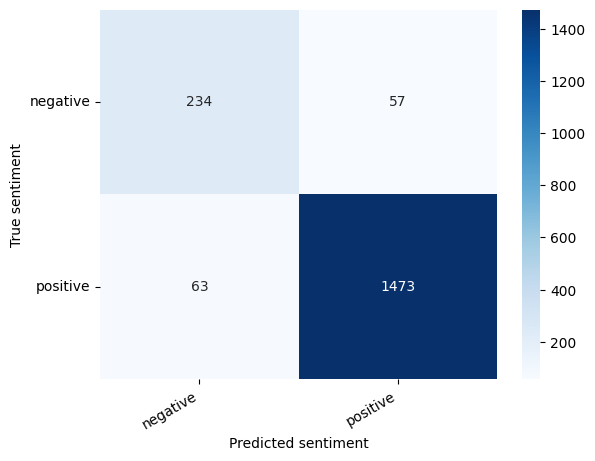

In [64]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [65]:
dd = pd.DataFrame(
    {
     'y_review_texts':y_review_texts,
     'y_test':y_test,
     'y_pred':[v[0] for v in y_pred],
     'y_pred_probs':y_pred_probs,
    }
)

In [66]:
dd[dd['y_test'] != dd['y_pred']].head()

,y_review_texts,y_test,y_pred,y_pred_probs
15,love mcdougall food product one quite measure ...,0.0,1,[0.9986761212348938]
16,unbearably hot unbearably go within one day ge...,1.0,0,[0.003589513711631298]
32,start disclaimer neither husband nor kind trai...,1.0,0,[0.2330416440963745]
37,water good thirsty fiji certainly taste soft l...,0.0,1,[0.9901943802833557]
77,self heating work fine long not weather below ...,0.0,1,[0.9972875118255615]


## Prediction

In [68]:
def pred_disaster(review_text, model):
    class_names = ['no_disaster', 'disaster']    # 1, 0
    tokenizer = CONFIG['TOKENIZER']
    max_len = CONFIG['MAX_LEN']

    encoded_review = tokenizer.encode_plus(
      review_text,
      max_length=max_len,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    # logits = output.logits.detach().cpu()
    prediction = torch.sigmoid(output).cpu().detach().numpy()
    print(output)
    print(torch.sigmoid(output))
    return prediction[0][0]

def predict(model, sentence):
    start_time = time.time()
    positive_prediction = pred_disaster(sentence, model)
    negative_prediction = 1 - positive_prediction
    response = {}
    response["response"] = {
        "positve": str(positive_prediction),
        "negative": str(negative_prediction),
        "sentence": str(sentence)
    }
    return response

In [69]:
predict(model, 'deeds reason earthquake may allah forgive us')

tensor([[0.6891]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.6658]], device='cuda:0', grad_fn=<SigmoidBackward0>)


{'response': {'positve': '0.6657764',
  'negative': '0.3342236280441284',
  'sentence': 'deeds reason earthquake may allah forgive us'}}

In [70]:
review_text = "I love completing my todos!!!"
predict(model, review_text)

tensor([[4.9486]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.9930]], device='cuda:0', grad_fn=<SigmoidBackward0>)


{'response': {'positve': '0.99295664',
  'negative': '0.007043361663818359',
  'sentence': 'I love completing my todos!!!'}}

In [71]:
review_text = "I hate implementation of  transfomers"
predict(model, review_text)

tensor([[-4.7696]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0084]], device='cuda:0', grad_fn=<SigmoidBackward0>)


{'response': {'positve': '0.008412504',
  'negative': '0.9915874963626266',
  'sentence': 'I hate implementation of  transfomers'}}